# Imports

In [1]:
import os
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import stereoid.tropical_cyclones.backscatter as backscatter
from stereoid.tropical_cyclones.wave_spectra import Kudry_spec
from stereoid.tropical_cyclones.Doppler import DopRIM

# Wave numbers
Two-dimensional wave spectrum running from -k_max..k_max in the x- and y-direction (cross and along track).
Wave number spacing is not equal and should cover long >100 m gravity waves up to the gravity-capillary range ~0.02 m.

In [2]:
# wavelengths and wave numbers
n_k = 500  # number of frequencies single side (total 2*n_k - 1)
lambda_max = 1000  # maximum wave length
k_min = 2 * np.pi / lambda_max  # minimum wave number
k_x = k_min * np.arange( 1, n_k )  # vector of wave numbers (single side)
k_x[ 20: ] = k_x[ 20: ] * 1.015 ** np.arange( 1, n_k - 20 )  # extend domain (distance increase higher wave noms)
k_x = np.append( np.append( -np.flip( k_x ), 0 ), k_x )  # double sided spectrum
k_m = (k_x[ 1: ] + k_x[ :-1 ]) / 2  # middle between k_x, needed for patch size
dk = np.absolute( k_m[ 1: ] - k_m[ :-1 ] )
dk = np.append( np.append( dk[ 0 ], dk ), dk[ 0 ] )  # dk is one-dimensional patch size
k_x = np.dot( np.ones( (n_k * 2 - 1, 1) ), k_x.reshape( 1, n_k * 2 - 1 ) )  # two dimensional
k_y = np.transpose( k_x )
k = np.sqrt( k_x ** 2 + k_y ** 2 )
phi = np.arctan2( k_y, k_x )  # 0 is cross-track direction waves, 90 along-track
dks = np.outer( dk, dk )  # patch size

# Wave spectra and backscatter
The wave spectrum and backscatter are based on Kudryavtsev et al. (2005). For completeness, you mights require K99, K03, KJ04 and some others. The iterative procedure to solve the wave spectrum is described in Yuroskaya et al. (2013) and KMC14. For now, we exclude the capillary wave balance (we expect this will not have a significant influence on the result). The Doppler is based on Hansen et al. (2012), in the code H12. For further details, see Chapron 2005 and Johanssen et al. (2008). For the cross-pol backscatter we use Kudryavtsev et al. (2019), to which in the monostatic case only Bragg and wave breaking contribute. We assume at this point the Doppler of wave breaking and Bragg is the same in cross-pol and for co-pol.

In [3]:
# a bit of input
pol = 'V' # polarization
u_10 = 10 # wind speed
fetch = 500E3 # fetch length
phi_r = 0 # radar direction
alpha = 0 # bistatic angle

# more input for Doppler
k_sw=0.01 # wave number swell (assumed monochromatic)
A_sw=0 # swell amplitude
phi_sw=0 # swell direction
v_c=0 # current velocity
phi_c=0 # current direction


theta=np.arange(15,51,5) # incident angles
phi_w=np.arange(0,361,30) # wind directions
sigma_sp=np.zeros((len(theta),len(phi_w))) # backscatter for each component
sigma_br=np.zeros((len(theta),len(phi_w)))
sigma_wb=np.zeros((len(theta),len(phi_w)))
sigma_br_cr=np.zeros((len(theta),len(phi_w)))
sigma_wb_cr=np.zeros((len(theta),len(phi_w)))
dopp_sp=np.zeros((len(theta),len(phi_w))) # Doppler for each component
dopp_br=np.zeros((len(theta),len(phi_w)))
dopp_wb=np.zeros((len(theta),len(phi_w)))
dopp_br_cr=np.zeros((len(theta),len(phi_w)))
dopp_wb_cr=np.zeros((len(theta),len(phi_w)))
q=np.zeros((len(theta),len(phi_w))) # this will always be same
for w in range(0,len(phi_w)): # go through wind directions
    
    # Kudryavtsev spectrum (now I compute a spectrum for each wind direction, not really necessary)
    B,_,_,_=Kudry_spec(k_x,k_y,u_10,fetch,phi_w[w],dks)
    S=np.where(k>0,B*k**-4,0)
    
    #plt.figure()
    #plt.imshow(B,vmin=0,vmax=5E-3)
    #plt.colorbar()
    #plt.show()
    
    
    for t in range(0,len(theta)): # go through incident angles
        
        # Radar Imaging Model (RIM) 
        sigma_sp[t,w], sigma_br[t,w], sigma_wb[t,w], q[t,w] = backscatter.backscatter_Kudry2005( S, k_x, k_y, dks, phi_w[w], theta = theta[ t ],
                                                                         pol = pol,
                                                                         u_10 = u_10, k_r = 0 )
        
        # ratio of scattering
        rat = np.array( [ sigma_sp[t,w] * (1 - q[t,w]), sigma_br[t,w] * (1 - q[t,w]), sigma_wb[t,w] * q[t,w] ] ) / (
                sigma_sp[t,w] * (1 - q[t,w]) + sigma_br[t,w] * (1 - q[t,w]) + sigma_wb[t,w] * q[t,w])
        
        # Doppler RIM (DopRIM)
        V, c_sp_bar, c_wb_bar, c_br_bar, c_sp, c_wb, c_br = DopRIM( S, k_x, k_y, dks, theta[t], alpha, v_c,
                                                                    phi_c, k_sw, phi_sw, A_sw, phi_w[w], u_10, pol = 'V',
                                                                    rat = rat )
        
        # Doppler components (specular, Bragg, wave breaking)
        dopp_sp[t,w]=rat[0]*(c_sp_bar+c_sp) # note that c_sp is actually c_sp*sL_sp (eq. 5 + 8 in H12)
        dopp_br[t,w]=rat[1]*(c_br_bar+c_br)
        dopp_wb[t,w]=rat[2]*(c_wb_bar+c_wb)
        
        # now get the cross-pol
        sigma_br_cr[t,w], sigma_wb_cr[t,w] = backscatter.backscatter_crosspol( S, k_x, k_y, dks, theta = theta[t], alpha = 0, u_10 = u_10, k_r = 0, fetch = fetch)
        
        # ratio of scattering
        rat = np.array( [ 0, sigma_br_cr[t,w]*(1-q), sigma_wb_cr[t,w]*q ] ) / ( sigma_br_cr[t,w]*(1-q) + sigma_wb_cr[t,w]*q )
        
        # use the individual results of the DopRIM (Doppler components)
        #dopp_br_cr[t,w]=rat[1]*(c_br_bar+c_br)
        #dopp_wb_cr[t,w]=rat[2]*(c_wb_bar+c_wb)
        dopp_wb_cr[t,w]=(c_wb_bar+c_wb) # only Doppler from wave breaking

# Plots

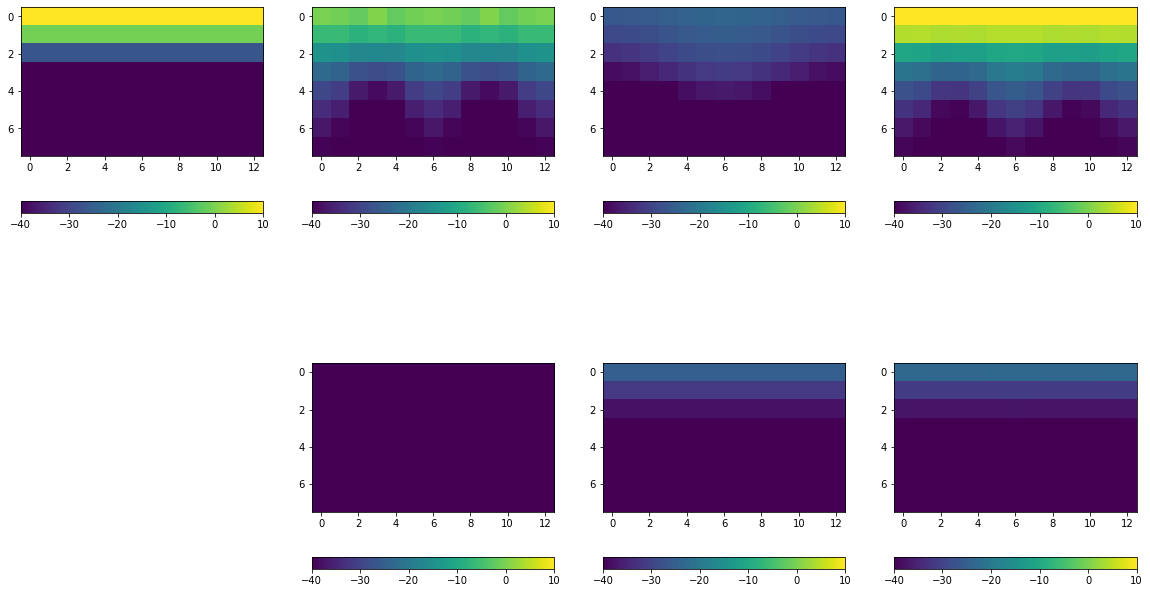

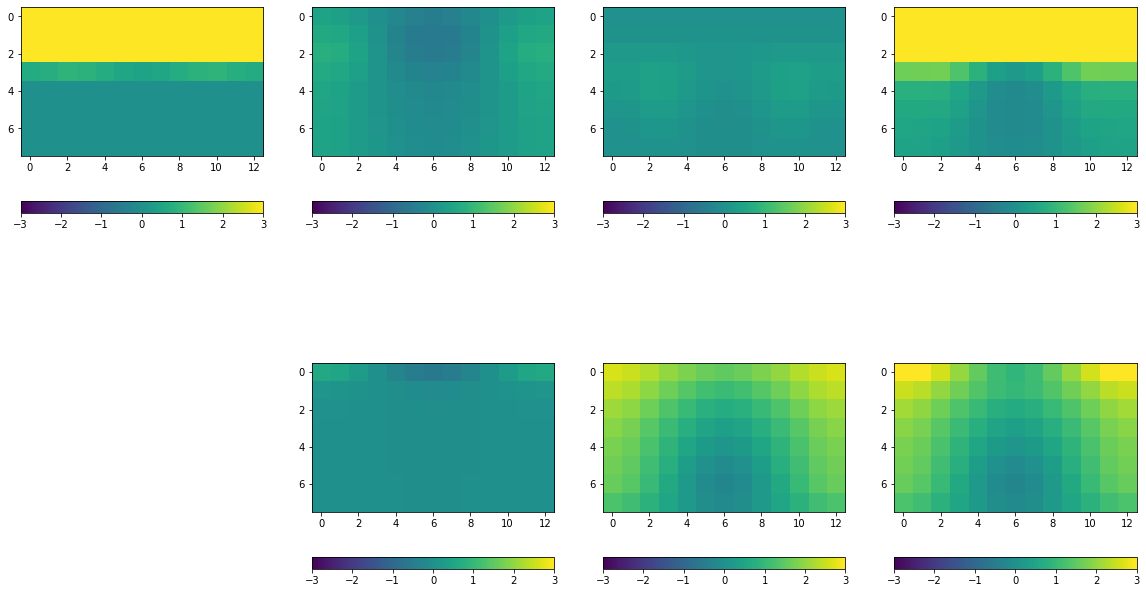

In [4]:
plt.figure(figsize=(20,12))
plt.subplot(2,4,1)
plt.imshow(10*np.log(sigma_sp*(1-q)),vmin=-40,vmax=10)
plt.colorbar(orientation='horizontal')
plt.subplot(2,4,2)
plt.imshow(10*np.log(sigma_br*(1-q)),vmin=-40,vmax=10)
plt.colorbar(orientation='horizontal')
plt.subplot(2,4,3)
plt.imshow(10*np.log(sigma_wb*q),vmin=-40,vmax=10)
plt.colorbar(orientation='horizontal')
plt.subplot(2,4,4)
plt.imshow(10*np.log(sigma_sp*(1-q)+sigma_br*(1-q)+sigma_wb*q),vmin=-40,vmax=10)
plt.colorbar(orientation='horizontal')
plt.subplot(2,4,6)
plt.imshow(10*np.log(sigma_br_cr),vmin=-40,vmax=10)
plt.colorbar(orientation='horizontal')
plt.subplot(2,4,7)
plt.imshow(10*np.log(sigma_wb_cr),vmin=-40,vmax=10)
plt.colorbar(orientation='horizontal')
plt.subplot(2,4,8)
plt.imshow(10*np.log(sigma_br_cr+sigma_wb_cr),vmin=-40,vmax=10)
plt.colorbar(orientation='horizontal')

plt.figure(figsize=(20,12))
plt.subplot(2,4,1)
plt.imshow(dopp_sp,vmin=-3,vmax=3)
plt.colorbar(orientation='horizontal')
plt.subplot(2,4,2)
plt.imshow(dopp_br,vmin=-3,vmax=3)
plt.colorbar(orientation='horizontal')
plt.subplot(2,4,3)
plt.imshow(dopp_wb,vmin=-3,vmax=3)
plt.colorbar(orientation='horizontal')
plt.subplot(2,4,4)
plt.imshow(dopp_sp+dopp_br+dopp_wb,vmin=-3,vmax=3)
plt.colorbar(orientation='horizontal')
plt.subplot(2,4,6)
plt.imshow(dopp_br_cr,vmin=-3,vmax=3)
plt.colorbar(orientation='horizontal')
plt.subplot(2,4,7)
plt.imshow(dopp_wb_cr,vmin=-3,vmax=3)
plt.colorbar(orientation='horizontal')
plt.subplot(2,4,8)
plt.imshow(dopp_br_cr+dopp_wb_cr,vmin=-3,vmax=3)
plt.colorbar(orientation='horizontal')


(5.995784377086521e-06, 0.0015891736436224459)